# Attention 

In [13]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch import optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
import torch.nn.functional as F

from tqdm.notebook import trange, tqdm

Loading dataset: 

In [9]:
# Folder where the dataset is used
data_set_root = "./data"

In [8]:
# Downloading the mnist (training set)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])])
dataset = datasets.MNIST(data_set_root, train=True, download=True, transform=transform)

# Selecting randomly 100 examples
number_of_examples = 100
rand_perm = torch.randperm(dataset.data.shape[0])[:number_of_examples]
dataset_tensor = torch.cat([dataset.__getitem__(i)[0].reshape(1,-1) for i in rand_perm])

Visualizing the dataset:

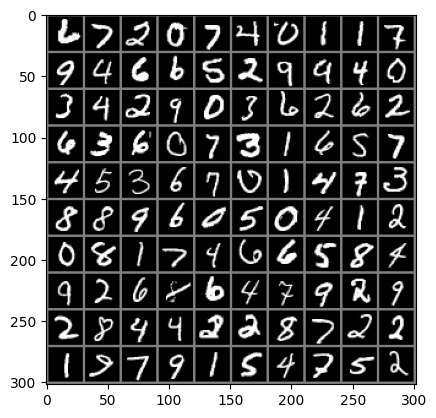

In [7]:
out = torchvision.utils.make_grid(dataset_tensor.reshape(-1, 1, 28, 28), 10, normalize=True, pad_value=0.5)
plt.imshow(out.numpy().transpose(1,2,0))

## Indexing the dataset
The tensor has now all the data. We can index on the first dimension to get different images.

Each image is `28x28` pixels, in total784 pixels per image. 
We used 100 images from the example image. We see in the tensor shape: 

In [10]:
dataset_tensor.shape

torch.Size([100, 784])

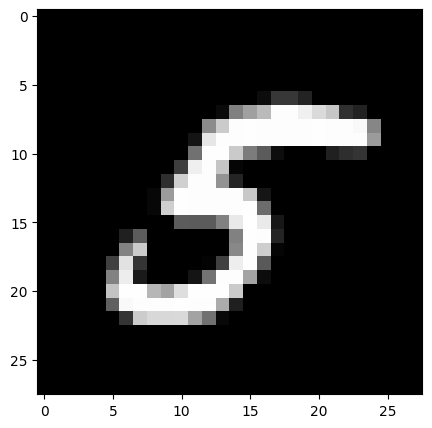

In [12]:
# Showing individual example image
image_index = 2
assert image_index < 100
plt.figure(figsize=(5,5))
plt.imshow(dataset_tensor[image_index].reshape(28,28).numpy(), cmap="gray")

## Introduction to V, K, Q matrices

We can assume that we have the dataset tensor. For now assume a `3x2` matrix:
This will be our value tensor with the dataset.

```math
\begin{bmatrix}
a & b \\
c & d \\
e & f
\end{bmatrix}
```

We can assign a unique vector to each of the rows with one-hot vector. 
In this case we will have a new matrix with rows. Which will then require it to be `3x3`. 

Key is then the one-hot encoded tensor: 
```math
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 
\end{bmatrix}
```


A query vector would then relate to the values through the keys. 
If we query the first row we get the following query row from the key matrix: 

```math
\begin{bmatrix}
1 & 0 & 0 
\end{bmatrix}
```


Then if we multiply our Q with K Transposed and V: 

`(1x3)*(3x2) = (1x2)`

```math
\begin{bmatrix}
1 & 0 & 0 
\end{bmatrix}

\times 

\begin{bmatrix}
a & b \\
c & d \\
e & f
\end{bmatrix}

=

\begin{bmatrix}
    a & b \\
\end{bmatrix}
```

We can now query rows in our dataset! 
Note that: 
- Dataset represents our V (value) matrix
- We made a one-hot encoded matrix for each row in the dataset, known as K (key)
- When we wanted to query a row, we used the `i-th` row of the Key matrix to use as a query to get the `i-th` row in the data tensor.
- Multiply Q with V to get the row in the dataset
- The order of rows 


Test this with the code below:



In [25]:
# Query vector by doing one hot encoding 
q_vec = F.one_hot(torch.tensor([image_index]), number_of_examples)

# Key vector by doing one-hot encoding for every image
k_vec = F.one_hot(torch.arange(number_of_examples), number_of_examples)

# Shuffle dataset
rand_perm = torch.randperm(number_of_examples)
k_vec = k_vec[rand_perm]
dataset_tensor_random = dataset_tensor[rand_perm]

In [26]:
q_vec

tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [27]:
k_vec

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [31]:
# Multiply key vector 
index_map = torch.mm(q_vec, k_vec.t()).float()

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

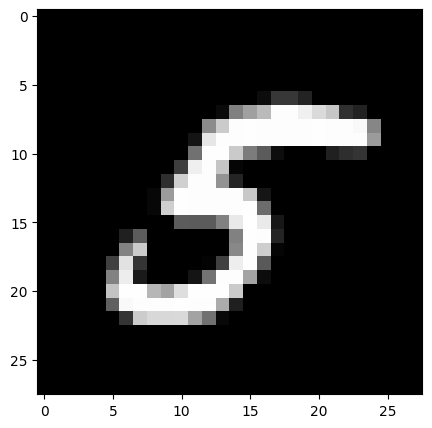

In [29]:
# Showing the output
output = torch.mm(index_map, dataset_tensor_random)
plt.figure(figsize=(5,5))
plt.imshow(output.reshape(28,28).numpy(), cmap="gray")

## Attention as "soft" look-up

This mechanism is used to look up values in the dataset with matrix multiplication. Attention is this lookup with matrix multiplication. 

We used one-hot encoded K. Q, K and V are going to be outputs from our neural network, and not be discrete values. We want to make this lookup mechanism to work with continuous value. 

We want the Query to be a probability over all values. The sum of the query vector should be 1. As a result is a weighted sum when we multiply it by keys, to get a weighted sum. 

In [104]:
# Defining the size of each vector 
vec_size = 512

# Creating a random Query vector
q_random_vec = torch.rand(1, vec_size)

# Create random key vector for each image in the dataset
random_keys = torch.rand(number_of_examples, vec_size)

# Calculate attention map and doing a Softmax
attention_map = torch.mm(q_random_vec, random_keys.t()).float()
attention_map = F.softmax(attention_map, -1)

# Indexing 
output = torch.mm(attention_map, dataset_tensor)

In [105]:
print(f"The largest softmax value is {attention_map.max().item()}")

The largest softmax value is 0.8475599884986877


Checking the attention maps values:

In [106]:
attention_map

tensor([[1.1338e-07, 3.3201e-05, 3.8626e-09, 2.9085e-04, 1.7701e-06, 3.4993e-05,
         3.0405e-06, 3.1821e-05, 1.7529e-04, 2.0466e-03, 2.3780e-03, 1.1049e-06,
         5.5819e-08, 2.4161e-06, 8.5595e-05, 1.9693e-05, 7.3307e-03, 3.2440e-05,
         1.4872e-06, 1.9200e-04, 1.3675e-06, 2.8544e-06, 2.9435e-04, 1.4351e-06,
         2.4093e-06, 4.0340e-04, 4.6182e-02, 9.6326e-06, 5.5250e-05, 2.7673e-04,
         3.0958e-03, 7.1130e-05, 1.4473e-04, 6.7445e-09, 2.3754e-05, 1.0843e-05,
         2.0936e-07, 3.6003e-06, 6.7670e-05, 8.9334e-08, 3.5942e-05, 2.9736e-07,
         4.0259e-07, 2.7655e-06, 3.1503e-07, 5.9467e-09, 3.9131e-07, 6.4033e-06,
         1.4308e-06, 1.4441e-05, 1.0980e-05, 3.8327e-06, 2.0428e-06, 4.3346e-08,
         1.1047e-06, 2.3704e-03, 2.8854e-08, 4.7207e-09, 2.6757e-02, 7.0203e-06,
         1.0208e-06, 4.1723e-07, 8.4756e-01, 6.7805e-06, 1.0274e-05, 1.3065e-06,
         6.9749e-03, 8.6688e-05, 6.7245e-04, 1.0885e-05, 1.4198e-04, 9.0412e-07,
         1.1140e-04, 9.8323e

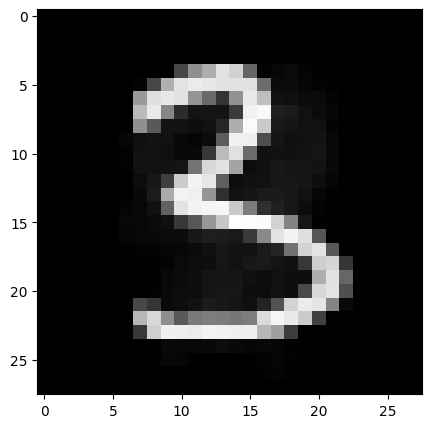

In [107]:
# Printing the results
plt.figure(figsize=(5,5))
plt.imshow(output.reshape(28,28).numpy(), cmap="gray")

Sometimes it does find a good match, but a lot of times it does not. In those cases we get a mismatch between the image and what we expected to be a clear number. By increasing the dimension of the vector will improve the attention map performance. 

Notice that we have initialized the Q and K with random values. This means there are __no semantic values between the query and keys__. 

We did $QK^T$ to calculate the similarities between the query and keys. High coloration will lead to high values in the attention map. This is by chance, and are currently not learnable parameters yet. We make them into probabilities by doing a softmax to get the probabilities over the attention map. 

Multiple queries is handled by extending the Q dimension. For example we can go from our original query and add another dimension. The results are a tensor that indexes multiple indexes. Note that each query is independent of each other. The attention map is now an extra dimension for the extra query. With code: 

In [110]:
# Defining the size of each vector 
vec_size = 512

# Amount of queries 
number_of_q = 8

# Creating a random Query vector
q_random_vec = torch.rand(number_of_q, vec_size)

# Create random key vector for each image in the dataset
random_keys = torch.rand(number_of_examples, vec_size)

# Calculate attention map and doing a Softmax
attention_map = torch.mm(q_random_vec, random_keys.transpose(0,1)).float()
attention_map = F.softmax(attention_map, -1)

# Indexing 
output = torch.mm(attention_map, dataset_tensor)

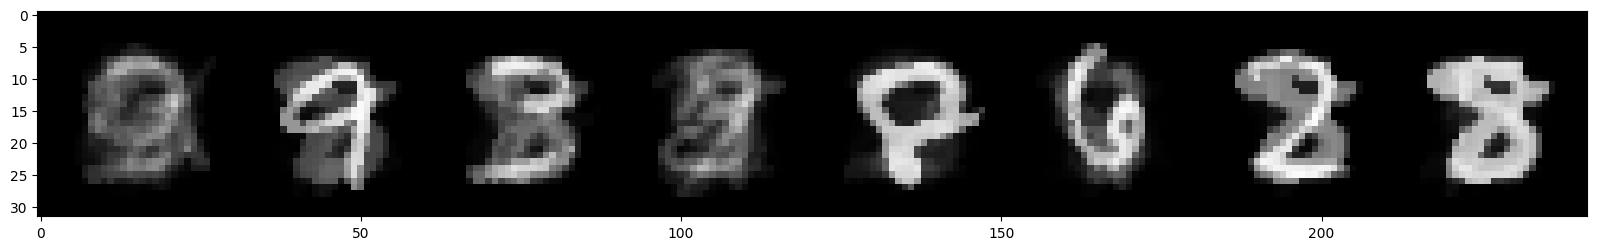

In [112]:
# Results for all queries 
plt.figure(figsize=(20,10))
out = torchvision.utils.make_grid(output.reshape(number_of_q, 1, 28, 28), 8, normalize=True)
plt.imshow(out.numpy().transpose((1,2,0)))